#Прогин балки.

#Прогин балки.

Геометрично нелінійний випадок

$\cfrac{d^2w}{dx^2}=\cfrac{M(x)}{EI} \left( 1+ \left(\cfrac{dw}{dx} \right)^2 \right)^{3/2}$

Лінійний випадок

$\cfrac{d^2w}{dx^2}=\cfrac{M(x)}{EI}$



##Защемлення


![picture](https://drive.google.com/uc?id=19vWQY0lymRwPEDH2wq3UlpscL9E-5VVI)


Граничні умови

$w(0)=0,$
$\cfrac{dw}{dx}(0)=0$

Розв'язок

$w=\cfrac{-P}{EI}x^2 \left( \cfrac{L}{2} - \cfrac{x}{6} \right)$



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import math


In [ ]:
L = 1.0
q = 30.0
# G = 2.77 * 10**4
# nu = 0.3
# E = 2*G*(1+nu)
E = 70.0*10**9
h = 0.01
I = math.pi * (h**4)/64
print(I)

4.908738521234052e-10


In [ ]:
q/(E*I)


0.8730785449612545

In [ ]:
def w(x, q, E, I, L):
    return q/(E*I)*x**2*(L/2 - x/6)

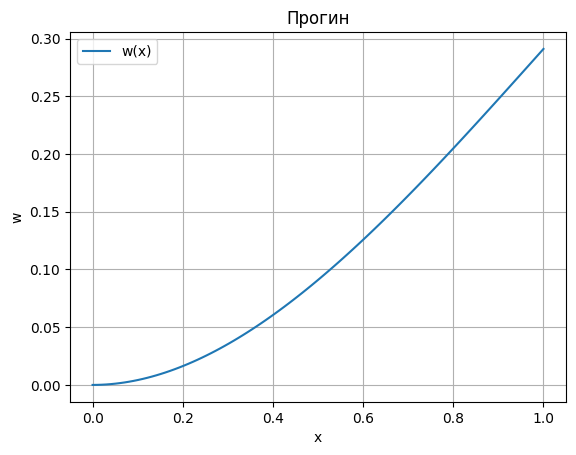

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Генерація значень x в діапазоні від -10 до 10
x_values = np.linspace(0, L, 100)

# Обчислення значень y за допомогою функції
y_values = w(x_values, q, E, I, L)

# Побудова графіка
plt.plot(x_values, y_values, label='w(x)')
plt.title('Прогин')
plt.xlabel('x')
plt.ylabel('w')
plt.legend()
plt.grid(True)
plt.show()


#Розв'язок за допомогою PINN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1,64),
            nn.Tanh(),
            # nn.Linear(64,64),
            # nn.Tanh(),
            # nn.Linear(64,64),
            # nn.ReLU(),
            nn.Linear(64,1),
            # nn.ReLU()
        )
        self.double()

    def forward(self, x):
        out = self.net(x)
        return out

In [ ]:
class Net:

    def __init__(self, num_iterations, num_points, q, L, E, I):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        print(device)
        self.device = device

        self.model = NN().to(device)

        self.x_max = L



        # comp. domain
        self.h = 0.01

        self.E = torch.tensor([E], requires_grad=True).double().to(device)
        self.q = torch.tensor([q], requires_grad=True).double().to(device)
        self.I = torch.tensor([I], requires_grad=True).double().to(device)
        self.L = torch.tensor([L], requires_grad=True).double().to(device)


        self.epoch = num_iterations


        x_vals = torch.linspace(0, self.x_max, num_points, requires_grad = True)
        self.X = torch.stack([x_vals.double()], dim=1)


        # print('self.X ', self.X.shape)
        # breakpoint()



        # train data
        bc1 = torch.tensor([self.x_max],  requires_grad = True).view(-1,1)

        ic  = torch.tensor([0.0],  requires_grad = True)
        ic = ic.view(-1,1)
        ic = ic.double()


        self.X_train = torch.cat([ic, ic])

        self.bc1 = bc1
        self.ic = ic

        print('self.bc1 ', self.bc1.shape)
        # print('self.bc1 ', self.bc1)
        print('self.ic ', self.ic.shape)
        # print('self.ic ', self.ic)
        # breakpoint()

        self.y_bc1 = torch.tensor([0]).double()


        # y_ic  = ic[:,0] / (1 + torch.exp((ic[:,0]**2 - 0.25)/(4*self.nu)))

        self.y_ic  = torch.tensor([0]).double()


        self.y_train = torch.cat([self.y_bc1, self.y_bc1, self.y_ic, self.y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        # print('self.y_train ', self.y_train.shape)




        self.X = self.X.to(device)
        self.bc1 = self.bc1.to(device)
        self.ic = self.ic.to(device)
        self.y_train = self.y_train.to(device)

        # self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 2000,
            max_eval = 2000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        # breakpoint()

        self.bc1 = self.bc1.double()
        ub = self.model(self.bc1)

        # breakpoint()

        ui = self.model(self.ic)

        # print('ub ', ub.shape)
        # print('ui ', ui.shape)
        # breakpoint()


        dub_dx = torch.autograd.grad(
            ub,
            self.bc1,
            grad_outputs = torch.ones_like(ub),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('dub_dx ', dub_dx.shape)
        # breakpoint()


        dub_dxx = torch.autograd.grad(
            dub_dx,
            self.bc1,
            grad_outputs = torch.ones_like(dub_dx),
            create_graph = True,
            retain_graph = True
        )[0]

        dub_dxxx = torch.autograd.grad(
            dub_dxx,
            self.bc1,
            grad_outputs = torch.ones_like(dub_dxx),
            create_graph = True,
            retain_graph = True
        )[0]





        # print('dub_dxx ', dub_dxx.shape)
        # breakpoint()


        dui_dx = torch.autograd.grad(
            ui,
            self.ic,
            grad_outputs = torch.ones_like(ui),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('dui_dx ', dui_dx.shape)
        # breakpoint()

        self.y_pred = torch.cat([dub_dxx, dub_dxxx, ui, dui_dx])




        # print('self.y_pred ', self.y_pred[0].shape)


        # loss_data = self.criterion(self.y_bc1, ub) + self.criterion(self.y_bc1, (self.bc1)*dub_dxx + self.nu*dub_dx) + self.criterion(self.y_ic, dui_dx)
        loss_data = self.criterion(self.y_pred - self.y_train, torch.zeros_like(self.y_train))


        # print('loss_data ', loss_data.shape)
        # breakpoint()

        u = self.model(self.X)

        du_dx = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dx ', du_dx.shape)
        # breakpoint()

        du_dxx = torch.autograd.grad(
            du_dx,
            self.X,
            grad_outputs = torch.ones_like(du_dx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dxx ', du_dxx.shape)
        # breakpoint()

        du_dxxx = torch.autograd.grad(
            du_dxx,
            self.X,
            grad_outputs = torch.ones_like(du_dxx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dxxx ', du_dxxx.shape)
        # breakpoint()

        du_dxxxx = torch.autograd.grad(
            du_dxxx,
            self.X,
            grad_outputs = torch.ones_like(du_dxxx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dxxxx ', du_dxxxx.shape)
        # breakpoint()

        residual = du_dxx

        p = self.q*self.L-self.q*self.X

        residual_r = (p)/(self.E*self.I)*(1+(du_dx)**2)**(3/2)


        loss_pde = self.criterion(residual-residual_r.double().to(self.device), torch.zeros_like(residual))
        # loss_pde = self.criterion(residual-torch.tensor([self.q/1.0]).double()*1 * (self.X*self.X*self.X), torch.zeros_like(residual))


        loss = loss_pde + loss_data
        loss.backward()


        # print('loss ', loss.shape)
        # breakpoint()

        if self.iter % 100 == 0:
            print("itration", self.iter, "loss", loss.item() )
            # print(self.iter, loss.item())
            # print(loss_pde.item())
            # print(loss_data.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epoch):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [ ]:
# training
num_iterations = 40000
num_points = 600
# a = 0.4
# q = 0.1
# G = 2.77 * 10**4
# nu = 0.3
# E = 2*G*(1+nu)
# h = 18*10**(-3)
# D = E*h**3/(12*(1-nu**2))
# print(E)
# print(D)



net = Net(num_iterations, num_points, q, L, E, I)

net.train()

cuda
self.bc1  torch.Size([1, 1])
self.ic  torch.Size([1, 1])


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


itration 100 loss 0.07731119710708681
itration 200 loss 0.019065755628758563
itration 300 loss 0.008278942913189972
itration 400 loss 0.006667209127483001
itration 500 loss 0.005762792410082925
itration 600 loss 0.005200235978379719
itration 700 loss 0.004824622443738261
itration 800 loss 0.004546768374675256
itration 900 loss 0.004315873698788497
itration 1000 loss 0.004105230456637688
itration 1100 loss 0.0039023664395328047
itration 1200 loss 0.003702353989815754
itration 1300 loss 0.003503875150683179
itration 1400 loss 0.0033071502924096044
itration 1500 loss 0.0031128722974829394
itration 1600 loss 0.002921662390665645
itration 1700 loss 0.0027338340899150486
itration 1800 loss 0.0025493371158159086
itration 1900 loss 0.0023677703634460588
itration 2000 loss 0.002188384437345366
itration 2100 loss 0.0020100175334714383
itration 2200 loss 0.0018308361020006041
itration 2300 loss 0.0016473084752138367
itration 2400 loss 0.0014495593631091278
itration 2500 loss 0.0012026777045540675

In [ ]:
net.model.eval()

NN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

##Test

In [ ]:
# h = 0.01
# k = 0.01
# a = 0.4

# x_vals = torch.linspace(0, a-0.00001, 50)


# X = torch.stack([x_vals.double()], dim=1)
# X = X.to(net.X.device)

In [ ]:
model = net.model
model.eval()
with torch.no_grad():

    x_vals = torch.linspace(0, L-0.00001, 500)


    input_data = torch.stack([x_vals.double()], dim=1)
    input_data = input_data.to(net.device)
    solution = model(input_data)
    sol = torch.stack([x_vals, solution.flatten().cpu()], dim=1)

    print(sol)


tensor([[0.0000e+00, 2.5671e-07],
        [2.0040e-03, 1.8636e-06],
        [4.0080e-03, 6.9648e-06],
        [6.0120e-03, 1.5554e-05],
        [8.0160e-03, 2.7625e-05],
        [1.0020e-02, 4.3172e-05],
        [1.2024e-02, 6.2188e-05],
        [1.4028e-02, 8.4667e-05],
        [1.6032e-02, 1.1060e-04],
        [1.8036e-02, 1.3999e-04],
        [2.0040e-02, 1.7282e-04],
        [2.2044e-02, 2.0909e-04],
        [2.4048e-02, 2.4879e-04],
        [2.6052e-02, 2.9192e-04],
        [2.8056e-02, 3.3847e-04],
        [3.0060e-02, 3.8843e-04],
        [3.2064e-02, 4.4180e-04],
        [3.4068e-02, 4.9856e-04],
        [3.6072e-02, 5.5872e-04],
        [3.8076e-02, 6.2227e-04],
        [4.0080e-02, 6.8920e-04],
        [4.2084e-02, 7.5951e-04],
        [4.4088e-02, 8.3319e-04],
        [4.6092e-02, 9.1022e-04],
        [4.8096e-02, 9.9062e-04],
        [5.0100e-02, 1.0744e-03],
        [5.2104e-02, 1.1614e-03],
        [5.4108e-02, 1.2519e-03],
        [5.6112e-02, 1.3456e-03],
        [5.811

In [ ]:
sol_np = sol.numpy()
np.shape(sol_np)
points = sol_np[:, 0]
points

array([0.        , 0.00200399, 0.00400798, 0.00601196, 0.00801595,
       0.01001994, 0.01202393, 0.01402792, 0.0160319 , 0.01803589,
       0.02003988, 0.02204387, 0.02404786, 0.02605184, 0.02805583,
       0.03005982, 0.03206381, 0.03406779, 0.03607178, 0.03807577,
       0.04007976, 0.04208375, 0.04408774, 0.04609172, 0.04809571,
       0.0500997 , 0.05210369, 0.05410768, 0.05611166, 0.05811565,
       0.06011964, 0.06212363, 0.06412762, 0.06613161, 0.06813559,
       0.07013958, 0.07214357, 0.07414756, 0.07615154, 0.07815553,
       0.08015952, 0.08216351, 0.0841675 , 0.08617149, 0.08817548,
       0.09017946, 0.09218345, 0.09418744, 0.09619142, 0.09819541,
       0.1001994 , 0.10220339, 0.10420737, 0.10621136, 0.10821535,
       0.11021934, 0.11222333, 0.11422732, 0.11623131, 0.11823529,
       0.12023928, 0.12224327, 0.12424726, 0.12625125, 0.12825523,
       0.13025922, 0.13226321, 0.1342672 , 0.13627118, 0.13827518,
       0.14027916, 0.14228316, 0.14428714, 0.14629112, 0.14829

In [ ]:
pred_y = []
true_y = []
pred_y = sol_np[:, 1]
for x in points:
    true_y.append(w(x, q, E, I, L))

print(true_y)

[0.0, 1.7519566568000421e-06, 7.003142297888581e-06, 1.5746529210863213e-05, 2.7975094557061626e-05, 4.368181021385465e-05, 6.285963996673453e-05, 8.55015751472144e-05, 0.0001116005811523049, 0.00014114963148558957, 0.000174141699650652, 0.0002105697591510756, 0.0002504267448531916, 0.0002937057043577678, 0.0003403995757149867, 0.0003905013324284319, 0.0004440039480016868, 0.0005009003414797922, 0.0005611836497419601, 0.0006248466221748018, 0.000691882468964475, 0.0007622839143925107, 0.0008360441936978995, 0.0009131560061615869, 0.0009936124593027942, 0.0010774066855106987, 0.0011645313467613064, 0.0012549797404685144, 0.0013487445038689802, 0.0014458189590637023, 0.0015461957186544836, 0.0016498681293249302, 0.001756828779146485, 0.001867071039280867, 0.001980587259314347, 0.0020973712568335885, 0.002217415589364655, 0.0023407132303915387, 0.002467256676898102, 0.002597039843338513, 0.0027300552387528364, 0.0028662953241131157, 0.0030057540859755295, 0.003148423997289952, 0.003294298

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot

def plot_feature(true_y, pred_y, points):

    fig_prices = go.Figure()
    fig_prices.add_trace(go.Scatter(x=points, y=true_y,
                        # fill= 'tonexty',
                        mode='lines',
                        # line_color='indigo',
                        name="Лінійний розв'язок"))
    fig_prices.add_trace(go.Scatter(
                        x=points,
                        y=pred_y,
                        # fill='tonexty', # fill area between trace0 and trace1
                        mode='lines',
                        # line_color='red',
                        name="Нелінійний розв'язок"))


    fig_prices.update_layout(yaxis_title="Значення функції")
    fig_prices.update_layout(
    xaxis=dict(
        title='Точки колокації',
        title_font=dict(size=20),  # Збільшення розміру шрифту підпису осі X
        tickfont=dict(size=16),    # Збільшення розміру шрифту тікерів-
    ),
    yaxis=dict(
        title='Значення функції',
        title_font=dict(size=20),  # Збільшення розміру шрифту підпису осі Y
        tickfont=dict(size=16),    # Збільшення розміру шрифту тікерів
    ),
    legend=dict(
        font=dict(size=18)          # Збільшення розміру шрифту легенди
    )
)
    fig_prices.show()

    return 0

In [ ]:
plot_feature(true_y, pred_y, points)

0

In [ ]:
import pandas as pd
import numpy as np

# Об'єднання масивів в DataFrame та назви стовпців
df = pd.DataFrame({'True': true_y, 'Pred': np.round(pred_y, 6)})

# Вивід DataFrame
print(df)

         True      Pred
0    0.000000  0.000000
1    0.000002  0.000002
2    0.000007  0.000007
3    0.000016  0.000016
4    0.000028  0.000028
..        ...       ...
495  0.287523  0.308601
496  0.288397  0.309573
497  0.289272  0.310544
498  0.290147  0.311515
499  0.291022  0.312486

[500 rows x 2 columns]


#Обернена задача

In [ ]:
class Net_inv:

    def __init__(self, num_iterations, num_points, q, L, I, uf):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        print(device)

        self.device = device

        self.qEI_true = 0.8731
        self.L_true = 1.0
        # self.E_true = 72020.0

        lambda_value = 1.0
        l_lambda_value = 2.0

        print("the real value =",self.qEI_true, "     Our I-PINNs value=", lambda_value)
        print("the real value =",self.L_true, "     Our I-PINNs value=", l_lambda_value)

        self.lambda_value = torch.tensor([lambda_value], requires_grad=True).double().to(device)

        self.lambda_value = nn.Parameter(self.lambda_value)

        self.l_lambda_value = torch.tensor([l_lambda_value], requires_grad=True).double().to(device)

        self.l_lambda_value = nn.Parameter(self.l_lambda_value)


        self.model = NN().to(device)

        self.model.register_parameter('lambda_value', self.lambda_value)
        self.model.register_parameter('l_lambda_value', self.l_lambda_value)

        self.x_max = L

        self.L = L


        # comp. domain
        self.h = 0.01

        self.I =torch.tensor([I], requires_grad=True).double().to(device)
        self.q = torch.tensor([q], requires_grad=True).double().to(device)

        # self.D = D

        self.epoch = num_iterations
        self.lambda_hist = []
        self.l_lambda_hist = []


        x_vals = torch.linspace(0, self.x_max, num_points, requires_grad = True)
        self.X = torch.stack([x_vals.double()], dim=1)


        # print('self.X ', self.X.shape)
        # breakpoint()



        # train data
        bc1 = torch.tensor([self.x_max],  requires_grad = True).view(-1,1)

        ic  = torch.tensor([0.0],  requires_grad = True)
        ic = ic.view(-1,1)
        ic = ic.double()


        self.X_train = torch.cat([bc1, ic])

        self.bc1 = bc1
        self.ic = ic

        # print('self.bc1 ', self.bc1.shape)
        # print('self.bc1 ', self.bc1)
        # print('self.ic ', self.ic.shape)
        # print('self.ic ', self.ic)
        # breakpoint()

        self.y_bc1 = torch.tensor([0]).double()


        # y_ic  = ic[:,0] / (1 + torch.exp((ic[:,0]**2 - 0.25)/(4*self.nu)))

        self.y_ic  = torch.tensor([0]).double()


        self.y_train = torch.tensor(uf)

        self.y_train = self.y_train.view(-1)
        self.y_train = self.y_train.unsqueeze(1)

        print('self.y_train ', self.y_train.shape)

        self.y_train_b = torch.cat([self.y_train[0], self.y_train[0], self.y_train[0], self.y_train[0]])

        print('self.y_train_b ', self.y_train_b.shape)





        self.X = self.X.to(device)
        self.bc1 = self.bc1.to(device)
        self.ic = self.ic.to(device)
        self.y_train = self.y_train.to(device)
        # self.X.requires_grad = True

        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 2000,
            max_eval = 2000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()


        self.bc1 = self.bc1.double()
        ub = self.model(self.bc1)

        # breakpoint()

        ui = self.model(self.ic)

        # print('ub ', ub.shape)
        # print('ui ', ui.shape)
        # breakpoint()


        dub_dx = torch.autograd.grad(
            ub,
            self.bc1,
            grad_outputs = torch.ones_like(ub),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('dub_dx ', dub_dx.shape)
        # breakpoint()


        dub_dxx = torch.autograd.grad(
            dub_dx,
            self.bc1,
            grad_outputs = torch.ones_like(dub_dx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('dub_dxx ', dub_dxx.shape)
        # breakpoint()

        dub_dxxx = torch.autograd.grad(
            dub_dxx,
            self.bc1,
            grad_outputs = torch.ones_like(dub_dxx),
            create_graph = True,
            retain_graph = True
        )[0]



        dui_dx = torch.autograd.grad(
            ui,
            self.ic,
            grad_outputs = torch.ones_like(ui),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('dui_dx ', dui_dx.shape)
        # breakpoint()

        self.y_pred_b = torch.cat([dub_dxx, dub_dxxx, ui, dui_dx])

        self.y_pred_b = self.y_pred_b.view(-1)

        # self.y_pred_b = self.y_pred_b.unsqueeze(1)

        # print('self.y_pred_b ', self.y_pred_b.shape)
        # breakpoint()






        self.y_pred =  self.model(self.X)

        # loss_data = self.criterion(self.y_bc1, ub) + self.criterion(self.y_bc1, (self.bc1)*dub_dxx + self.nu*dub_dx) + self.criterion(self.y_ic, dui_dx)
        # loss_data = self.criterion(self.y_pred - self.y_train, torch.zeros_like(self.y_train))
        loss_data = self.criterion(self.y_pred, self.y_train)

        loss_data_b = self.criterion(self.y_pred_b, self.y_train_b)

        # print('loss_data ', loss_data.shape)
        # breakpoint()

        u = self.model(self.X)

        du_dx = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dx ', du_dx.shape)
        # breakpoint()

        du_dxx = torch.autograd.grad(
            du_dx,
            self.X,
            grad_outputs = torch.ones_like(du_dx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dxx ', du_dxx.shape)
        # breakpoint()

        du_dxxx = torch.autograd.grad(
            du_dxx,
            self.X,
            grad_outputs = torch.ones_like(du_dxx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dxxx ', du_dxxx.shape)
        # breakpoint()

        du_dxxxx = torch.autograd.grad(
            du_dxxx,
            self.X,
            grad_outputs = torch.ones_like(du_dxxx),
            create_graph = True,
            retain_graph = True
        )[0]

        # print('du_dxxxx ', du_dxxxx.shape)
        # breakpoint()


        residual = du_dxx


        residual_r = self.lambda_value*(self.l_lambda_value -self.X)*(1+(du_dx)**2)**(3/2)

        # loss_pde = self.criterion(residual-self.lambda_value, torch.zeros_like(residual))
        loss_pde = self.criterion(residual, residual_r)
        # loss_pde = self.criterion(residual, self.q/(self.lambda_value*self.I))

        loss = loss_pde + loss_data + loss_data_b
        loss.backward()


        # print('loss ', loss.shape)
        # breakpoint()

        self.lambda_hist.append(self.lambda_value.item())
        self.l_lambda_hist.append(self.l_lambda_value.item())

        if self.iter % 100 == 0:
            # print("itration", self.iter, "loss", loss.item() )
            print("iteration number =",self.iter, " loss =", loss.item(),
                  " loss data =", loss_data.item(), " loss pde =", loss_pde.item(),
                  " real qEI=", self.qEI_true, " real L=", self.L_true, " IPINN lambda=", self.lambda_value.item(),
                  " IPINN l_lambda=", self.l_lambda_value.item())
            # print(self.iter, loss.item())
            # print(loss_pde.item())
            # print(loss_data.item())
        self.iter = self.iter+1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epoch):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

##Test

In [ ]:
solution.shape

torch.Size([500, 1])

In [ ]:
net_inv = Net_inv(80000, 500, q, L, I, solution)
net_inv.train()
net_inv.model.eval()

cuda
the real value = 0.8731      Our I-PINNs value= 1.0
the real value = 1.0      Our I-PINNs value= 2.0
self.y_train  torch.Size([500, 1])
self.y_train_b  torch.Size([4])


<ipython-input-36-1004b0a116aa>:87: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



iteration number = 100  loss = 0.7655214829614138  loss data = 0.008434554286153573  loss pde = 0.5192730803568824  real qEI= 0.8731  real L= 1.0  IPINN lambda= 0.9151751512212547  IPINN l_lambda= 1.9154825643808837
iteration number = 200  loss = 0.38149149420975054  loss data = 0.006237418592938514  loss pde = 0.24044712738499924  real qEI= 0.8731  real L= 1.0  IPINN lambda= 0.8519938808769111  IPINN l_lambda= 1.8521180885421007
iteration number = 300  loss = 0.22208739155566476  loss data = 0.005021006707288708  loss pde = 0.11969994569689366  real qEI= 0.8731  real L= 1.0  IPINN lambda= 0.8039367713047424  IPINN l_lambda= 1.8027699793760916
iteration number = 400  loss = 0.16906972518494434  loss data = 0.0037561073234385783  loss pde = 0.07342124892734551  real qEI= 0.8731  real L= 1.0  IPINN lambda= 0.7681806194317086  IPINN l_lambda= 1.7646983357841368
iteration number = 500  loss = 0.1390319044001643  loss data = 0.002970437807062333  loss pde = 0.05505926088035864  real qEI= 0.

NN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
with torch.no_grad():

    x_vals_inv = torch.linspace(0, L, 200)


    input_data_inv = torch.stack([x_vals_inv.double()], dim=1).to(net.device)
    solution_inv = net_inv.model(input_data_inv)
    sol_inv = torch.stack([x_vals_inv, solution_inv.flatten().cpu()], dim=1)

    print(sol)

tensor([[0.0000e+00, 2.5671e-07],
        [2.0040e-03, 1.8636e-06],
        [4.0080e-03, 6.9648e-06],
        [6.0120e-03, 1.5554e-05],
        [8.0160e-03, 2.7625e-05],
        [1.0020e-02, 4.3172e-05],
        [1.2024e-02, 6.2188e-05],
        [1.4028e-02, 8.4667e-05],
        [1.6032e-02, 1.1060e-04],
        [1.8036e-02, 1.3999e-04],
        [2.0040e-02, 1.7282e-04],
        [2.2044e-02, 2.0909e-04],
        [2.4048e-02, 2.4879e-04],
        [2.6052e-02, 2.9192e-04],
        [2.8056e-02, 3.3847e-04],
        [3.0060e-02, 3.8843e-04],
        [3.2064e-02, 4.4180e-04],
        [3.4068e-02, 4.9856e-04],
        [3.6072e-02, 5.5872e-04],
        [3.8076e-02, 6.2227e-04],
        [4.0080e-02, 6.8920e-04],
        [4.2084e-02, 7.5951e-04],
        [4.4088e-02, 8.3319e-04],
        [4.6092e-02, 9.1022e-04],
        [4.8096e-02, 9.9062e-04],
        [5.0100e-02, 1.0744e-03],
        [5.2104e-02, 1.1614e-03],
        [5.4108e-02, 1.2519e-03],
        [5.6112e-02, 1.3456e-03],
        [5.811

In [ ]:
sol_np_inv = sol_inv.numpy()
np.shape(sol_np_inv)
points_inv = sol_np_inv[:, 0]
points_inv

array([0.        , 0.00502513, 0.01005025, 0.01507538, 0.0201005 ,
       0.02512563, 0.03015075, 0.03517588, 0.040201  , 0.04522613,
       0.05025126, 0.05527638, 0.06030151, 0.06532663, 0.07035176,
       0.07537688, 0.08040201, 0.08542714, 0.09045226, 0.09547739,
       0.10050251, 0.10552764, 0.11055277, 0.11557789, 0.12060301,
       0.12562814, 0.13065326, 0.1356784 , 0.14070351, 0.14572865,
       0.15075377, 0.1557789 , 0.16080402, 0.16582914, 0.17085427,
       0.17587939, 0.18090452, 0.18592964, 0.19095477, 0.19597989,
       0.20100503, 0.20603015, 0.21105528, 0.2160804 , 0.22110553,
       0.22613065, 0.23115578, 0.2361809 , 0.24120602, 0.24623115,
       0.25125629, 0.25628141, 0.26130652, 0.26633164, 0.27135679,
       0.27638191, 0.28140703, 0.28643215, 0.2914573 , 0.29648241,
       0.30150753, 0.30653265, 0.3115578 , 0.31658292, 0.32160804,
       0.32663316, 0.33165827, 0.33668342, 0.34170854, 0.34673366,
       0.35175878, 0.35678393, 0.36180905, 0.36683416, 0.37185

In [ ]:
pred_y_inv = []
true_y_inv = []
pred_y_inv = sol_np_inv[:, 1]
for x in points_inv:
    true_y_inv.append(w(x, q, E, I, L) )

print(true_y_inv)

[0.0, 1.1004975672112411e-05, 4.394604379211374e-05, 9.871240993267068e-05, 0.00017519330399776777, 0.00027327792948113024, 0.00039285544971440824, 0.0005338151650032799, 0.0006960462466255736, 0.0008794379062059862, 0.0010838793553692146, 0.001309259805739956, 0.0015554682787274371, 0.0018223943510698565, 0.0021099270595760114, 0.002417955615870598, 0.0027463692315783136, 0.0030950571183238555, 0.00346390848773192, 0.003852812551427205, 0.004261658521034407, 0.004690335608178223, 0.00513873302448335, 0.005606739981574486, 0.006094244953868183, 0.006601139364613569, 0.007127309419439563, 0.007672647450293049, 0.008237039434807178, 0.008820377931610501, 0.0094225486929686, 0.010043444501563503, 0.01068295088692141, 0.01134095887461306, 0.012017359709663179, 0.012712038592416914, 0.013424888854191486, 0.014155795479163145, 0.014904652013503905, 0.015671343227849324, 0.016455762880598017, 0.017257795531473028, 0.018077335148471395, 0.018914266083031837, 0.01976848251012161, 0.020639868575

In [ ]:
plot_feature(true_y_inv, pred_y_inv, points_inv)

0

In [ ]:

net_inv.lambda_hist

[1.0,
 0.9990000000020568,
 0.9980003616436647,
 0.9970012941789375,
 0.9960029961560248,
 0.9950056573975395,
 0.9940094614484066,
 0.9930145858997923,
 0.992021202351585,
 0.9910294766630627,
 0.9900395691834927,
 0.9890516347549644,
 0.9880658224958918,
 0.9870822754338066,
 0.9861011300678537,
 0.9851225159417676,
 0.9841465553006444,
 0.9831733628824293,
 0.98220304585576,
 0.9812357038775478,
 0.9802714292280617,
 0.9793103069888861,
 0.9783524152458871,
 0.9773978253142092,
 0.9764466019914616,
 0.9754988038485024,
 0.9745544835655051,
 0.9736136883155484,
 0.9726764601903456,
 0.971742836654796,
 0.9708128510106927,
 0.9698865328467143,
 0.9689639084525551,
 0.9680450011795525,
 0.9671298317373948,
 0.9662184184247764,
 0.9653107772994454,
 0.9644069222985016,
 0.9635068653222724,
 0.9626106162945965,
 0.9617181832095828,
 0.9608295721710026,
 0.9599447874266723,
 0.9590638313974758,
 0.9581867046995977,
 0.9573134061590093,
 0.9564439328187251,
 0.9555782799410123,
 0.95471644

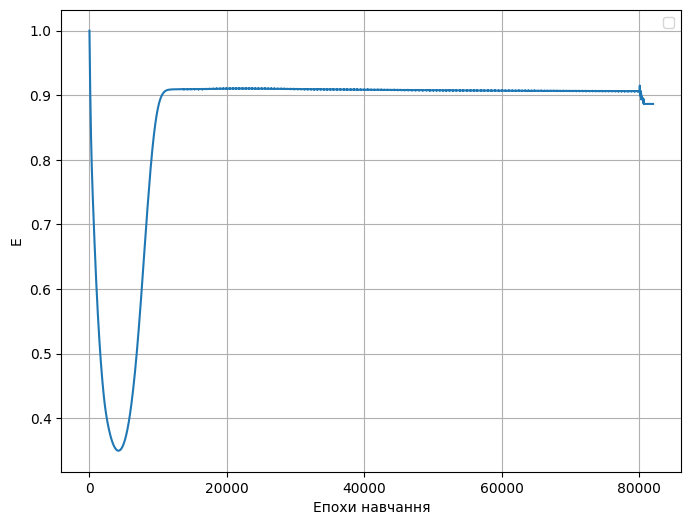

In [ ]:
# Побудова графіку
plt.figure(figsize=(8, 6))    # Розміри графіку (ширина, висота) в дюймах

plt.plot(net_inv.lambda_hist)

# Додавання заголовку, підписів вісей та легенди
# plt.title('Графік декількох кривих')
plt.xlabel('Eпохи навчання')
plt.ylabel('E')
# plt.ylim(0, 1)
plt.legend()   # Виведення легенди з назвами кривих

# Показати графік
plt.grid(True)   # Включити сітку
plt.show()


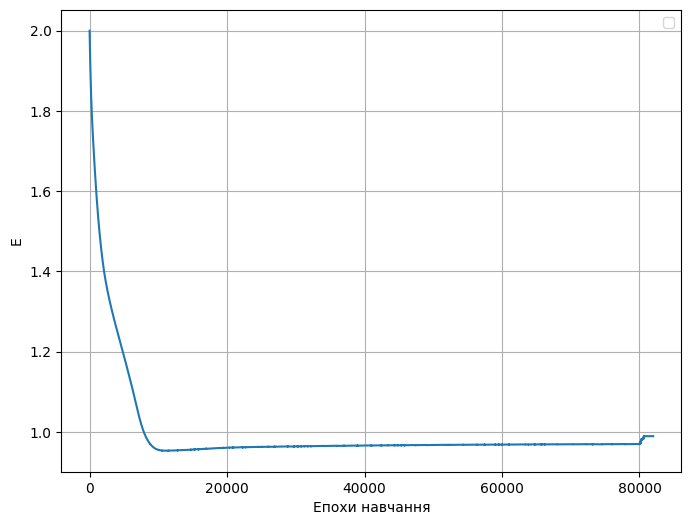

In [ ]:
# Побудова графіку
plt.figure(figsize=(8, 6))    # Розміри графіку (ширина, висота) в дюймах

plt.plot(net_inv.l_lambda_hist)

# Додавання заголовку, підписів вісей та легенди
# plt.title('Графік декількох кривих')
plt.xlabel('Eпохи навчання')
plt.ylabel('E')
# plt.ylim(0, 1)
plt.legend()   # Виведення легенди з назвами кривих

# Показати графік
plt.grid(True)   # Включити сітку
plt.show()


In [ ]:
import plotly.express as px
import pandas as pd

# Дані
epochs = list(range(1, len(net_inv.lambda_hist) + 1))  # Список епох навчання
E_values = net_inv.lambda_hist

# Створення DataFrame для зручності
data = pd.DataFrame({'Епохи': epochs, 'Значення q/EI': E_values})

# Побудова графіку за допомогою Plotly
fig = px.line(data, x='Епохи', y='Значення q/EI', title='Зміна значення q/EI під час навчання моделі', markers=True)
fig.update_layout(
    # title='Зміна значення E під час навчання моделі'
    title={
        'text': 'Зміна значення q/EI під час навчання моделі',
        'y':0.85,  # Вертикальне позиціонування заголовка
        'x':0.5,  # Горизонтальне вирівнювання по центру
        'xanchor': 'center',  # Центрування по осі x
        'yanchor': 'top',  # Якір для осі y
        'font': {'size':24, 'family':'Arial', 'color':'black'}
    },
    xaxis_title='Епохи навчання',
    yaxis_title='Значення параметра q/EI',
    xaxis=dict(title_font=dict(size=24, family='Arial', color='black')),
    yaxis=dict(title_font=dict(size=24, family='Arial', color='black')),
    font=dict(size=22, family='Arial'),
    template='plotly_white'
)
fig.update_xaxes(tickformat="t")

# Відображення графіку
fig.show()


In [ ]:
import plotly.express as px
import pandas as pd

# Дані
epochs = list(range(1, len(net_inv.lambda_hist) + 1))  # Список епох навчання
E_values = net_inv.l_lambda_hist

# Створення DataFrame для зручності
data = pd.DataFrame({'Епохи': epochs, 'Значення L': E_values})

# Побудова графіку за допомогою Plotly
fig = px.line(data, x='Епохи', y='Значення L', title='Зміна значення L під час навчання моделі', markers=True)
fig.update_layout(
    # title='Зміна значення E під час навчання моделі'
    title={
        'text': 'Зміна значення L під час навчання моделі',
        'y':0.85,  # Вертикальне позиціонування заголовка
        'x':0.5,  # Горизонтальне вирівнювання по центру
        'xanchor': 'center',  # Центрування по осі x
        'yanchor': 'top',  # Якір для осі y
        'font': {'size':24, 'family':'Arial', 'color':'black'}
    },
    xaxis_title='Епохи навчання',
    yaxis_title='Значення параметра L',
    xaxis=dict(title_font=dict(size=24, family='Arial', color='black')),
    yaxis=dict(title_font=dict(size=24, family='Arial', color='black')),
    font=dict(size=22, family='Arial'),
    template='plotly_white'
)
fig.update_xaxes(tickformat="t")

# Відображення графіку
fig.show()


In [ ]:
net_inv.qEI_true

0.8731

In [ ]:
net_inv.lambda_hist[-1]

0.886638290264838

In [ ]:
np.abs(net_inv.qEI_true - net_inv.lambda_hist[-1])/net_inv.qEI_true*100

1.55060019068125

In [ ]:
np.abs(net_inv.L_true - net_inv.l_lambda_hist[-1])/net_inv.L_true*100

1.0977663806230886